In [1]:
import torch
import torch.nn as nn


In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
df = pd.read_parquet('gun0_chunk_0.parquet', dtype_backend = 'pyarrow')[['X_jet','m']]

In [3]:
df.columns

Index(['X_jet', 'm'], dtype='object')

In [4]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
df = df.iloc[:6000]

In [6]:
# Convert to tensors
X = torch.tensor(df['X_jet'].values, dtype = torch.float32)
y = torch.tensor(df['m'].values, dtype = torch.float32)

In [7]:
df = None

In [8]:
print(X.shape, y.shape)

torch.Size([6000, 8, 125, 125]) torch.Size([6000])


In [9]:
# Separating into training and test data
testLen = 0.2*X.shape[0]
X_train = X[:int(X.shape[0]-testLen)]
y_train = y[:int(X.shape[0]-testLen)]

X_test = X[int(X.shape[0]-testLen):]
y_test = y[int(X.shape[0]-testLen):]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X = None
y = None

torch.Size([4800, 8, 125, 125]) torch.Size([4800])
torch.Size([1200, 8, 125, 125]) torch.Size([1200])


In [10]:
# Separating into training and validation data
valLen = 0.2*X_train.shape[0]

X_valid = X_train[:int(valLen)]
y_valid = y_train[:int(valLen)]

X_train = X_train[int(valLen):]
y_train = y_train[int(valLen):]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

torch.Size([3840, 8, 125, 125]) torch.Size([3840])
torch.Size([960, 8, 125, 125]) torch.Size([960])


In [11]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

torch.Size([3840, 8, 125, 125]) torch.Size([960, 8, 125, 125]) torch.Size([1200, 8, 125, 125])
torch.Size([3840]) torch.Size([960]) torch.Size([1200])


In [12]:
X_train = X_train.permute(0,3,2,1)
X_test = X_test.permute(0,3,2,1)
X_valid = X_valid.permute(0,3,2,1)

In [13]:
print(X_train.shape, X_valid.shape, X_test.shape)   

torch.Size([3840, 125, 125, 8]) torch.Size([960, 125, 125, 8]) torch.Size([1200, 125, 125, 8])


In [14]:
#Normalizing the Train and Validation data
X_train_mean = X_train.mean()
X_train_std = X_train.std()

X_train = (X_train - X_train_mean) / (X_train_std + 1e-6)
X_valid = (X_valid - X_train_mean) / (X_train_std + 1e-6)

In [15]:
# Create DataLoaders
from torch.utils.data import DataLoader, TensorDataset
trainSet = TensorDataset(X_train, y_train)
validSet = TensorDataset(X_valid, y_valid)
testSet = TensorDataset(X_test, y_test)

X_train = None
y_train = None
X_valid = None

batchSize = 32
trainLoader = DataLoader(trainSet, batch_size = batchSize, shuffle = True)
validLoader = DataLoader(validSet, batch_size = batchSize, shuffle = True)
testLoader = DataLoader(testSet, batch_size = batchSize, shuffle = True)

trainSet = None
validSet = None
testSet = None

In [16]:
for i in trainLoader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([32, 125, 125, 8]) torch.Size([32])


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomCNN(nn.Module):
    def __init__(self, base_hidden_units, weight_decay):
        super(CustomCNN, self).__init__()
        self.base_hidden_units = base_hidden_units
        self.weight_decay = weight_decay

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=base_hidden_units, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(base_hidden_units)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=base_hidden_units, out_channels=base_hidden_units, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(base_hidden_units)

        # Pool + Dropout
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.dropout1 = nn.Dropout(0.2)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=base_hidden_units, out_channels=base_hidden_units*2, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(base_hidden_units*2)

        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(in_channels=base_hidden_units*2, out_channels=base_hidden_units*2, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(base_hidden_units*2)

        # Pool + Dropout
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)
        self.dropout2 = nn.Dropout(0.2)

        # Convolutional Layer 5
        self.conv5 = nn.Conv2d(in_channels=base_hidden_units*2, out_channels=base_hidden_units*4, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(base_hidden_units*4)

        # Convolutional Layer 6
        self.conv6 = nn.Conv2d(in_channels=base_hidden_units*4, out_channels=base_hidden_units*4, kernel_size=3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(base_hidden_units*4)

        # Pool + Dropout
        self.maxpool3 = nn.MaxPool2d(kernel_size=3)
        self.dropout3 = nn.Dropout(0.2)

        # Fully Connected Layer 1
        self.fc = nn.Linear(base_hidden_units*4 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)

        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batchnorm3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.batchnorm4(x)

        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.batchnorm5(x)

        x = self.conv6(x)
        x = self.relu(x)
        x = self.batchnorm6(x)

        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = x.view(-1, self.base_hidden_units*4 * 4 * 4)  # Flatten
        x = self.fc(x)

        return x

# Initialize the model
base_hidden_units = 16
weight_decay = 2
model = CustomCNN(base_hidden_units, weight_decay).to(device)

# Print model summary
summary(model, input_size=(8, 125, 125))  # Assuming input image size is 32x32x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 125, 125]           1,168
              ReLU-2         [-1, 16, 125, 125]               0
       BatchNorm2d-3         [-1, 16, 125, 125]              32
            Conv2d-4         [-1, 16, 125, 125]           2,320
              ReLU-5         [-1, 16, 125, 125]               0
       BatchNorm2d-6         [-1, 16, 125, 125]              32
         MaxPool2d-7           [-1, 16, 41, 41]               0
           Dropout-8           [-1, 16, 41, 41]               0
            Conv2d-9           [-1, 32, 41, 41]           4,640
             ReLU-10           [-1, 32, 41, 41]               0
      BatchNorm2d-11           [-1, 32, 41, 41]              64
           Conv2d-12           [-1, 32, 41, 41]           9,248
             ReLU-13           [-1, 32, 41, 41]               0
      BatchNorm2d-14           [-1, 32,

In [18]:
criterion = nn.L1Loss()  # use mean squared error loss
#use sgd optimizer
optimiser = torch.optim.SGD(model.parameters(), lr=0.00002, weight_decay=weight_decay, momentum=0.5)


In [19]:
num_epochs = 50

In [20]:
# Training Loop
model.train()

CustomCNN(
  (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv

In [21]:
for image,label in trainLoader:
    print(image.shape)
    break

torch.Size([32, 125, 125, 8])


In [22]:
trainLoss = []
trainAccuracy = []

validLoss = []
validAccuracy = []

In [23]:
import gc

def write_accuracies(message, file_path):
    with open(file_path, 'a') as file:
        file.write(message)
        file.write('\n')

for epoch in range(num_epochs):
    batch = 1
    total_train_loss = 0
    

    # Training loop
    for i, (images, labels) in enumerate(trainLoader):
        # permute the image dimensions
        number = len(images)
        arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
        images = torch.stack(arr)

        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), torch.tensor(labels, dtype=torch.float))
        
        # Backward and optimize
        loss.backward()
        optimiser.step()

        total_train_loss += (loss.item())
        print(total_train_loss)
        # Memory cleanup
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

        #Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch}/{len(trainLoader)}, Train Loss: {loss.item():.4f}")
        batch += 1

    # Calculate training accuracy and loss
    training_loss = total_train_loss / len(trainLoader)
    trainLoss.append(training_loss)


    # Validation loop
    with torch.no_grad():
        total_val_loss = 0


        for images, labels in validLoader:
            # permute the image dimensions
            number = len(images)
            arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
            images = torch.stack(arr)

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            total_val_loss += (criterion(outputs, labels).item())

    # Calculate validation accuracy and loss
    validation_loss = total_val_loss / len(validLoader)

    validLoss.append(validation_loss)
    
    #Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    #Write losses to file
    write_accuracies(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}', "accuracies.txt")


322.2349548339844
Epoch [1/50], Batch 1/120, Train Loss: 322.2350


/tmp/ipykernel_6351/114619117.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
/tmp/ipykernel_6351/114619117.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs.squeeze(), torch.tensor(labels, dtype=torch.float))


623.5928649902344
Epoch [1/50], Batch 2/120, Train Loss: 301.3579
892.7886657714844
Epoch [1/50], Batch 3/120, Train Loss: 269.1958
1190.5266418457031
Epoch [1/50], Batch 4/120, Train Loss: 297.7380
1511.0756225585938
Epoch [1/50], Batch 5/120, Train Loss: 320.5490
1768.7218322753906
Epoch [1/50], Batch 6/120, Train Loss: 257.6462
2047.9097595214844
Epoch [1/50], Batch 7/120, Train Loss: 279.1879
2325.080841064453
Epoch [1/50], Batch 8/120, Train Loss: 277.1711
2617.6341247558594
Epoch [1/50], Batch 9/120, Train Loss: 292.5533
2910.2870178222656
Epoch [1/50], Batch 10/120, Train Loss: 292.6529
3219.6951293945312
Epoch [1/50], Batch 11/120, Train Loss: 309.4081
3508.31787109375
Epoch [1/50], Batch 12/120, Train Loss: 288.6227
3792.9236450195312
Epoch [1/50], Batch 13/120, Train Loss: 284.6058
4095.08642578125
Epoch [1/50], Batch 14/120, Train Loss: 302.1628
4360.4202880859375
Epoch [1/50], Batch 15/120, Train Loss: 265.3339
4667.4547119140625
Epoch [1/50], Batch 16/120, Train Loss: 307.

/tmp/ipykernel_6351/114619117.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
/home/ayushraina/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [1/50], Train Loss: 287.3401, Validation Loss: 284.4569
263.9321594238281
Epoch [2/50], Batch 1/120, Train Loss: 263.9322
557.2290344238281
Epoch [2/50], Batch 2/120, Train Loss: 293.2969
788.4902038574219
Epoch [2/50], Batch 3/120, Train Loss: 231.2612
1072.6208190917969
Epoch [2/50], Batch 4/120, Train Loss: 284.1306
1346.7705688476562
Epoch [2/50], Batch 5/120, Train Loss: 274.1497
1667.2386779785156
Epoch [2/50], Batch 6/120, Train Loss: 320.4681
1968.9349060058594
Epoch [2/50], Batch 7/120, Train Loss: 301.6962
2253.048797607422
Epoch [2/50], Batch 8/120, Train Loss: 284.1139
2541.2828063964844
Epoch [2/50], Batch 9/120, Train Loss: 288.2340
2834.1403198242188
Epoch [2/50], Batch 10/120, Train Loss: 292.8575
3109.5439453125
Epoch [2/50], Batch 11/120, Train Loss: 275.4036
3368.6038208007812
Epoch [2/50], Batch 12/120, Train Loss: 259.0599
3633.6786499023438
Epoch [2/50], Batch 13/120, Train Loss: 265.0748
3924.7630615234375
Epoch [2/50], Batch 14/120, Train Loss: 291.0844
42

In [24]:
with torch.no_grad():
    total_test_loss = 0

    for images, targets in testLoader:
        # permute the image dimensions
        number = len(images)
        arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
        images = torch.stack(arr)

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets.float())  # Using the same regression loss as in training

        total_test_loss += loss.item()

    # Calculate average test loss
    test_loss = total_test_loss / len(testLoader)

    print('Test Loss of the model on the test data: {:.4f}'.format(test_loss))
    write_accuracies('Test Loss of the model on the test data: {:.4f}'.format(test_loss), "accuracies.txt")


/tmp/ipykernel_6351/2806525297.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2, 0, 1) for i in images]


Test Loss of the model on the test data: 127.6032


/home/ayushraina/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


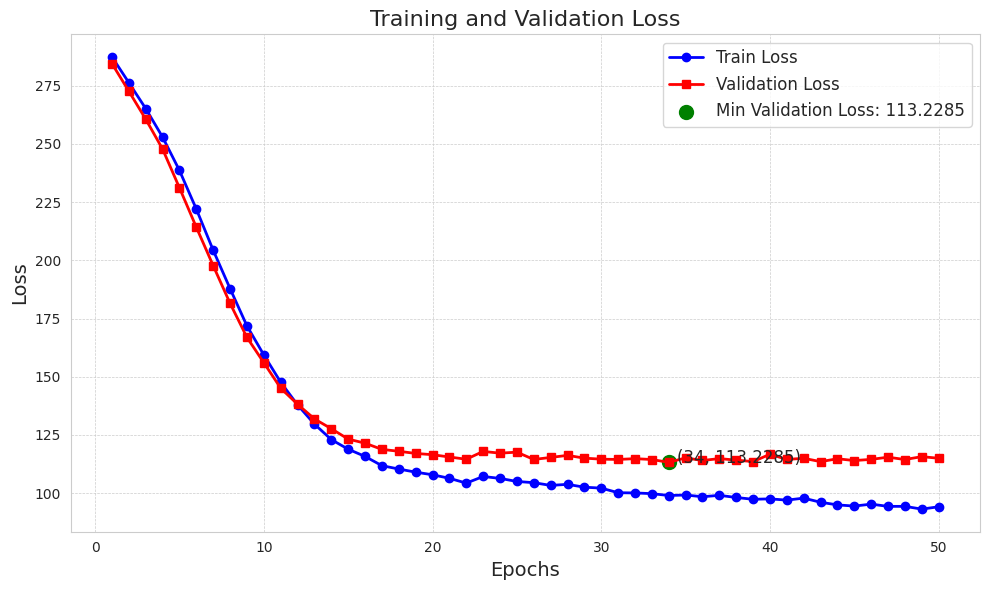

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Generate x values
x = list(range(1, num_epochs + 1))

# Plot train and validation losses
plt.plot(x, trainLoss, label='Train Loss', marker='o', color='b', linewidth=2)
plt.plot(x, validLoss, label='Validation Loss', marker='s', color='r', linewidth=2)

# Find the minimum validation loss
min_val_loss = min(validLoss)
min_val_loss_epoch = validLoss.index(min_val_loss) + 1

# Add labels to minimum validation loss point
plt.scatter(min_val_loss_epoch, min_val_loss, color='g', s=100, label=f'Min Validation Loss: {min_val_loss:.4f}')
plt.text(min_val_loss_epoch + 0.5, min_val_loss - 0.1, f'({min_val_loss_epoch}, {min_val_loss:.4f})', fontsize=12)

# Add labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)

# Add legend
plt.legend(fontsize=12)

# Add grid and set grid style
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# save the plot
plt.savefig('loss_plot.png')

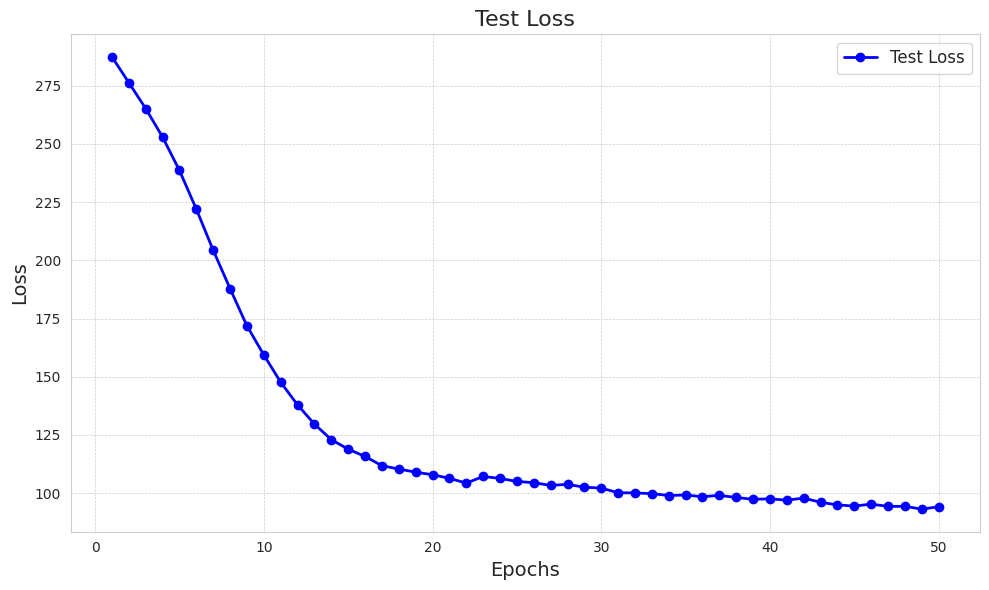

In [28]:
# Separate plot for train loss
plt.figure(figsize=(10, 6))

# Plot test loss
plt.plot(x, trainLoss, label='Test Loss', marker='o', color='b', linewidth=2)

# Add labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Test Loss', fontsize=16)

# Add legend
plt.legend(fontsize=12)

# Add grid and set grid style
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

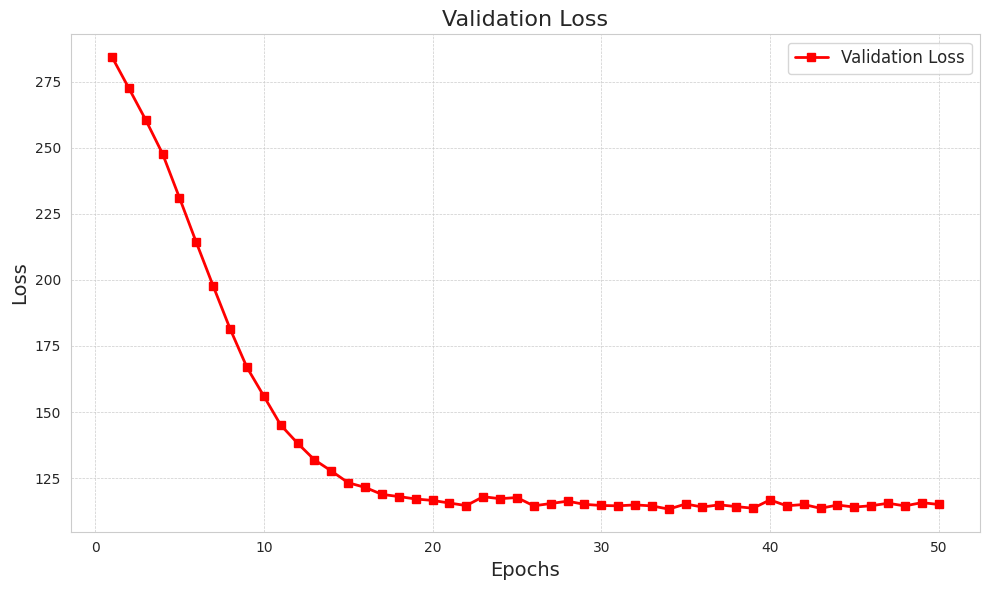

In [29]:
# Separate plot for validation loss
plt.figure(figsize=(10, 6))

# Plot validation loss
plt.plot(x, validLoss, label='Validation Loss', marker='s', color='r', linewidth=2)

# Add labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Validation Loss', fontsize=16)

# Add legend
plt.legend(fontsize=12)

# Add grid and set grid style
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

In [26]:
# save the model
torch.save(model.state_dict(), 'model.pth')